In [1]:
!pip install -q nltk  # for natural language processing
!pip install -q einops  # for handling tensors and arrays
!pip install -q pyngrok  # for tunneling local web servers to the internet
!pip install -q faiss-cpu  # for efficient similarity search and clustering
!pip install -q matplotlib  # for data visualization
!pip install -q pdfplumber  # for extracting text and tables from PDFs
!pip install -q python-docx  # for reading and writing .docx files
!pip install -q flask-ngrok  # for running Flask applications with ngrok
!pip install -q -U sentence-transformers  # for sentence embeddings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.9 MB/s eta 0:00:00


In [2]:
import os  # for operating system related functionalities
import re  # for regular expressions
import nltk  # for natural language processing tasks
import docx  # for working with Microsoft Word documents
import torch  # for deep learning with PyTorch
import faiss  # for similarity search and clustering
import random  # for generating random numbers and choices
import textwrap  # for text wrapping and filling
import pdfplumber  # for extracting text and data from PDF files
import numpy as np  # Importing numpy library with alias np for numerical computations
import pandas as pd  # Importing pandas library with alias pd for data manipulation and analysis
import matplotlib.pyplot as plt  # Importing matplotlib library with alias plt for creating visualizations
from pyngrok import ngrok  # for exposing local servers to the internet
from datetime import datetime  # for working with dates and times
from spacy.lang.en import English  # for natural language processing
from flask_ngrok import run_with_ngrok  # for integrating Flask with ngrok
from nltk.tokenize import word_tokenize  # for word tokenization
from nltk.tokenize import sent_tokenize  # for sentence tokenization
from sentence_transformers.util import cos_sim  # for cosine similarity calculation
from sentence_transformers import util, SentenceTransformer  # for generating sentence embeddings
from flask import Flask, render_template, request, jsonify, redirect, url_for  # for building web applications
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer, AutoModelForCausalLM
# for using Hugging Face models and pipelines

In [3]:
# Download the 'punkt' tokenizer models from NLTK
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Create an instance of the Flask class
app = Flask(__name__)
# Use the run_with_ngrok function to enable Ngrok tunneling for the Flask app
run_with_ngrok(app)

In [5]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [6]:
# Define the path to a folder in Google Drive where documents are stored
folder_path = "/content/drive/MyDrive/documents/"

**Document Parsing**

In [7]:
def extract_text_by_page_with_metrics_from_folder(folder_path):
    text_by_page = []

    # Iterate over each file in the specified folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if filename.endswith(".pdf"):
            # Extract text and metrics from each PDF file
            with pdfplumber.open(file_path) as pdf:
                for page_num, page in enumerate(pdf.pages, start=1):
                    page_text = page.extract_text()

                    # Replace newline characters ('\n') with spaces (' ')
                    page_text = page_text.replace('\n', ' ')

                    # Append page data to the list
                    text_by_page.append({
                        # Calculate character count
                        "char_count": len(page_text),
                        # Calculate word count
                        "word_count": len(word_tokenize(page_text)),
                        # Calculate sentence count (using raw tokenization)
                        "sentence_count": len(sent_tokenize(page_text)),
                        # Calculate average token count per word
                        "token_count": len(page_text) / 4, # 1 token = ~4 characters,
                        "text": page_text
                    })

        elif filename.endswith(".docx"):
            # Extract text and metrics from each Word document
            doc = docx.Document(file_path)
            merged_text = ""
            word_count = 0

            for paragraph in doc.paragraphs:
                # Replace non-breaking space ('\xa0') with regular space (' ')
                paragraph_text = paragraph.text.replace('\xa0', ' ')

                # Tokenize paragraph text to calculate word count
                words = word_tokenize(paragraph_text)
                paragraph_word_count = len(words)

                if paragraph_word_count < 50:
                    # Merge the current paragraph with the previous one
                    merged_text += " " + paragraph_text
                else:
                    # Append the merged text (if any) to the list
                    if merged_text:
                        text_by_page.append({
                            "char_count": len(merged_text),
                            "word_count": len(word_tokenize(merged_text)),
                            "sentence_count": len(sent_tokenize(merged_text)),
                            "token_count": len(merged_text) / 4,
                            "text": merged_text.strip()
                        })

                    # Reset for the next paragraph
                    merged_text = paragraph_text
                    word_count = paragraph_word_count

            # Append the last merged text (if any) to the list
            if merged_text:
                text_by_page.append({
                    "char_count": len(merged_text),
                    "word_count": len(word_tokenize(merged_text)),
                    "sentence_count": len(sent_tokenize(merged_text)),
                    "token_count": len(merged_text) / 4,
                    "text": merged_text.strip()
                })

    return text_by_page

# Extract text with metrics from PDF and Word files in the specified folder
text_segments_by_page = extract_text_by_page_with_metrics_from_folder(folder_path)

text_segments_by_page[17:19]

[{'char_count': 666,
  'word_count': 146,
  'sentence_count': 3,
  'token_count': 166.5,
  'text': '02/03/2024, 14:23 2023 in spaceflight - Wikipedia Partial Country Launches Successes Failures Remarks failures China 67 66 1 0 Europe 3 3 0 0 India 7 7 0 0 Iran 2 1 1 0 Israel 1 1 0 0 Japan 3 2 1 0 North 3 1 2 0 Korea Russia 19 19 0 0 South 2 2 0 0 Korea Includes Electron launches from Mahia United Broke world record of most launches by a 116 109 6 1 States nation (108) held by Soviet Union in 1982.[93][94] World 223 211 11 1 By rocket 100 90 80 70 60 50 40 30 20 10 Ceres Chŏllima Electron Falcon H-series Kuaizhou Long PSLV R-7 Others March https://en.wikipedia.org/wiki/2023_in_spaceflight#:~:text=NASA launched the Psyche spacecraft,to be a binary pair. 6/15'},
 {'char_count': 1876,
  'word_count': 410,
  'sentence_count': 2,
  'token_count': 469.0,
  'text': '02/03/2024, 14:23 2023 in spaceflight - Wikipedia Ceres-1 H3 Long March 7 Firefly Alpha Chŏllima 1 Kuaizhou-1A Long March 11 Hype

In [8]:
# Create a DataFrame from a list of dictionaries
text_segments_by_page_df = pd.DataFrame(text_segments_by_page)

# Display the first 5 rows of the DataFrame to inspect its contents
text_segments_by_page_df.head()

,char_count,word_count,sentence_count,token_count,text
0,392,55,1,98.0,From https://www.livescience.com/space/astrono...
1,1948,344,12,487.0,"Every year, we learn more about the intricacie..."
2,742,137,6,185.5,"However, this oxygen is not a sign of life on ..."
3,1202,224,8,300.5,"Researchers examined tiny impact crystals, kno..."
4,1438,272,12,359.5,Two leading theories explain the speed-up. The...


In [9]:
# .describe() computes descriptive statistics for numeric columns in the DataFrame
# .round(2) rounds all numerical values in the DataFrame `summary_stats` to 2 decimal places
text_segments_by_page_df.describe().round(2)

,char_count,word_count,sentence_count,token_count
count,39.00,39.00,39.00,39.00
mean,2920.44,530.46,28.97,730.11
std,2527.68,421.60,42.23,631.92
min,293.00,55.00,1.00,73.25
25%,1091.50,192.00,2.50,272.88
50%,1948.00,389.00,9.00,487.00
75%,3758.50,695.50,30.50,939.62
max,8381.00,1381.00,141.00,2095.25


**Splitting pages into sentences**

In [10]:
# Initialize the English language model provided by spaCy
nlp = English()

# Adding a sentencizer pipeline, see https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")
# it is not just splitting sentences by ., but also it is accounting for other
# rules and statistics. And it is robust.

for item in text_segments_by_page:
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

text_segments_by_page[17:19]

[{'char_count': 666,
  'word_count': 146,
  'sentence_count': 3,
  'token_count': 166.5,
  'text': '02/03/2024, 14:23 2023 in spaceflight - Wikipedia Partial Country Launches Successes Failures Remarks failures China 67 66 1 0 Europe 3 3 0 0 India 7 7 0 0 Iran 2 1 1 0 Israel 1 1 0 0 Japan 3 2 1 0 North 3 1 2 0 Korea Russia 19 19 0 0 South 2 2 0 0 Korea Includes Electron launches from Mahia United Broke world record of most launches by a 116 109 6 1 States nation (108) held by Soviet Union in 1982.[93][94] World 223 211 11 1 By rocket 100 90 80 70 60 50 40 30 20 10 Ceres Chŏllima Electron Falcon H-series Kuaizhou Long PSLV R-7 Others March https://en.wikipedia.org/wiki/2023_in_spaceflight#:~:text=NASA launched the Psyche spacecraft,to be a binary pair. 6/15',
  'sentences': ['02/03/2024, 14:23 2023 in spaceflight - Wikipedia Partial Country Launches Successes Failures Remarks failures China 67 66 1 0 Europe 3 3 0 0 India 7 7 0 0 Iran 2 1 1 0 Israel 1 1 0 0 Japan 3 2 1 0 North 3 1 2 0 Ko

**Chunking our sentences together (Chunk_size and overlap)**

In [11]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 4

# Create a function to split lists of texts recursively into chunk size
# e.g.  if chunk size = 10, then [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size+2] for i in range(0, len(input_list), slice_size)]
    # +2 is for overlapping

# Loop through pages and texts and split sentences into chunks
for item in text_segments_by_page:
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

text_segments_by_page[17:19]

[{'char_count': 666,
  'word_count': 146,
  'sentence_count': 3,
  'token_count': 166.5,
  'text': '02/03/2024, 14:23 2023 in spaceflight - Wikipedia Partial Country Launches Successes Failures Remarks failures China 67 66 1 0 Europe 3 3 0 0 India 7 7 0 0 Iran 2 1 1 0 Israel 1 1 0 0 Japan 3 2 1 0 North 3 1 2 0 Korea Russia 19 19 0 0 South 2 2 0 0 Korea Includes Electron launches from Mahia United Broke world record of most launches by a 116 109 6 1 States nation (108) held by Soviet Union in 1982.[93][94] World 223 211 11 1 By rocket 100 90 80 70 60 50 40 30 20 10 Ceres Chŏllima Electron Falcon H-series Kuaizhou Long PSLV R-7 Others March https://en.wikipedia.org/wiki/2023_in_spaceflight#:~:text=NASA launched the Psyche spacecraft,to be a binary pair. 6/15',
  'sentences': ['02/03/2024, 14:23 2023 in spaceflight - Wikipedia Partial Country Launches Successes Failures Remarks failures China 67 66 1 0 Europe 3 3 0 0 India 7 7 0 0 Iran 2 1 1 0 Israel 1 1 0 0 Japan 3 2 1 0 North 3 1 2 0 Ko

**Splitting each chunk into its own item (chunk information included)**

In [12]:
# Split each chunk into its own item
pages_and_chunks = []
for item in text_segments_by_page:
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        # chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A" (will work for any captial letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

pages_and_chunks[17:19]

[{'sentence_chunk': "This year, astronomers also noticed that all of Neptune's clouds had suddenly vanished. The disappearing act is likely linked to a peak in solar activity as the sun reaches the explosive peak in its roughly 11-year solar cycle, known as the solar maximum.  Pluto has an icy supervolcano  Researchers discovered that Pluto has a massive cryovolcano that is comparable in size to Yellowstone's supervolcano. (Image credit: NASA/JPL) Demoted planet Pluto has been hiding a gigantic cryovolcano the size of Yellowstone's supervolcano, an October study revealed.",
  'chunk_char_count': 557,
  'chunk_word_count': 87,
  'chunk_token_count': 139.25},
 {'sentence_chunk': 'Cryovolcanoes, also known as ice volcanoes, are simply volcanoes that erupt with cryomagma — ice, water and various gases — instead of molten rock. They\'ve been found in several places across the solar system, including the dwarf planet Ceres and at the heart of explosive comets, such as the "devil comet."',
  

**Filter chunks of text based on word count (data visualization)**

In [13]:
df = pd.DataFrame(pages_and_chunks)
df

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,From https://www.livescience.com/space/astrono...,387,46,96.75
1,"Every year, we learn more about the intricacie...",808,125,202.00
2,Image credit: NASA/Johns Hopkins University Ap...,985,153,246.25
3,"This year, scientists also discovered that sal...",753,114,188.25
4,"However, this oxygen is not a sign of life on ...",736,125,184.00
...,...,...,...,...
284,3. Click the Plot Table button and then select...,444,78,111.00
285,"This new feature is currently in Beta release,...",401,52,100.25
286,"02/03/2024, 14:17 2024 Exoplanet Archive News ...",1187,140,296.75
287,"02/03/2024, 14:17 2024 Exoplanet Archive News ...",1029,147,257.25


In [14]:
# It selects rows from `df` where the value in the "chunk_word_count" column is less than 11.
df[df["chunk_word_count"] < 11]

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
26,1/15,4,1,1.00
32,2/15,4,1,1.00
36,3/15,4,1,1.00
53,5/15,4,1,1.00
61,11/15,5,1,1.25
99,https://en.wikipedia.org/wiki/2023_in_spacefli...,119,9,29.75
135,https://en.wikipedia.org/wiki/2023_in_spacefli...,119,9,29.75
173,14/15,5,1,1.25
198,https://en.wikipedia.org/wiki/2024_in_spacefli...,114,9,28.50
280,https://exoplanetarchive.ipac.caltech.edu/docs...,152,10,38.00


In [15]:
# Select rows from the DataFrame where 'chunk_word_count' column value is greater than or equal to 11
df[df["chunk_word_count"] >= 11]

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,From https://www.livescience.com/space/astrono...,387,46,96.75
1,"Every year, we learn more about the intricacie...",808,125,202.00
2,Image credit: NASA/Johns Hopkins University Ap...,985,153,246.25
3,"This year, scientists also discovered that sal...",753,114,188.25
4,"However, this oxygen is not a sign of life on ...",736,125,184.00
...,...,...,...,...
284,3. Click the Plot Table button and then select...,444,78,111.00
285,"This new feature is currently in Beta release,...",401,52,100.25
286,"02/03/2024, 14:17 2024 Exoplanet Archive News ...",1187,140,296.75
287,"02/03/2024, 14:17 2024 Exoplanet Archive News ...",1029,147,257.25


In [16]:
# Filter our DataFrame for rows with under 11 words
word_length = 11
pages_and_chunks_over_min_word = df[df["chunk_word_count"] >= word_length].to_dict(orient="records")
pages_and_chunks_over_min_word[17:19]

[{'sentence_chunk': "This year, astronomers also noticed that all of Neptune's clouds had suddenly vanished. The disappearing act is likely linked to a peak in solar activity as the sun reaches the explosive peak in its roughly 11-year solar cycle, known as the solar maximum.  Pluto has an icy supervolcano  Researchers discovered that Pluto has a massive cryovolcano that is comparable in size to Yellowstone's supervolcano. (Image credit: NASA/JPL) Demoted planet Pluto has been hiding a gigantic cryovolcano the size of Yellowstone's supervolcano, an October study revealed.",
  'chunk_char_count': 557,
  'chunk_word_count': 87,
  'chunk_token_count': 139.25},
 {'sentence_chunk': 'Cryovolcanoes, also known as ice volcanoes, are simply volcanoes that erupt with cryomagma — ice, water and various gases — instead of molten rock. They\'ve been found in several places across the solar system, including the dwarf planet Ceres and at the heart of explosive comets, such as the "devil comet."',
  

**Perform embedding on our text chunks**

In [17]:
# Load the pre-trained model
sent_trans_model = SentenceTransformer('all-mpnet-base-v2')

Embedding = sent_trans_model.encode("Hello World !!!")
Embedding.shape # For Debugging

for item in pages_and_chunks_over_min_word:
    # Access the 'sentence_chunk' value of the current item and use the sent_trans_model to encode it
    # Set convert_to_tensor=False to get the embedding as a numpy array (not a PyTorch tensor)
    item["embedding"] = sent_trans_model.encode(item["sentence_chunk"], convert_to_tensor=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
pages_and_chunks_over_min_word[17:19]

[{'sentence_chunk': "This year, astronomers also noticed that all of Neptune's clouds had suddenly vanished. The disappearing act is likely linked to a peak in solar activity as the sun reaches the explosive peak in its roughly 11-year solar cycle, known as the solar maximum.  Pluto has an icy supervolcano  Researchers discovered that Pluto has a massive cryovolcano that is comparable in size to Yellowstone's supervolcano. (Image credit: NASA/JPL) Demoted planet Pluto has been hiding a gigantic cryovolcano the size of Yellowstone's supervolcano, an October study revealed.",
  'chunk_char_count': 557,
  'chunk_word_count': 87,
  'chunk_token_count': 139.25,
  'embedding': array([ 6.67175204e-02, -1.31492633e-02, -1.32642137e-02,  4.50358316e-02,
         -3.43824830e-03, -1.85020827e-02,  3.16420919e-03,  1.88703611e-02,
          1.17807060e-01,  6.70221522e-02,  1.08976858e-02,  8.83524772e-03,
         -6.92224503e-02, -1.87422410e-02,  5.80923725e-03, -6.22118004e-02,
          2.71

**Saving embeddings into csv file**

In [19]:
# Save embeddings to file
sentence_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_word)
embeddings_df_save_path = "sentence_chunks_and_embeddings_df.csv"
sentence_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [20]:
sentence_chunks_and_embeddings_df.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,From https://www.livescience.com/space/astrono...,387,46,96.75,"[0.024271091, 0.062412098, 0.026181014, -0.006..."
1,"Every year, we learn more about the intricacie...",808,125,202.00,"[0.029122017, 0.00995556, -0.021805443, -0.040..."
2,Image credit: NASA/Johns Hopkins University Ap...,985,153,246.25,"[0.016429814, -0.059618887, -0.02158487, -0.02..."
3,"This year, scientists also discovered that sal...",753,114,188.25,"[0.051210865, -0.029339662, -0.01691759, -0.00..."
4,"However, this oxygen is not a sign of life on ...",736,125,184.00,"[0.06478167, -0.017821431, -0.018014168, 0.003..."


In [21]:
sentence_chunks_and_embeddings_df.describe().round(2)

,chunk_char_count,chunk_word_count,chunk_token_count
count,279.00,279.00,279.00
mean,562.54,77.13,140.64
std,467.60,89.26,116.90
min,76.00,11.00,19.00
25%,289.00,26.00,72.25
50%,384.00,36.00,96.00
75%,626.00,88.50,156.50
max,2303.00,478.00,575.75


**Fetch data from the csv file**

In [22]:
# Import texts and embedding df
chunks_and_embeddings_df = pd.read_csv("sentence_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to CSV)
chunks_and_embeddings_df["embedding"] = chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Stack embeddings into a NumPy array
embeddings_array = np.stack(chunks_and_embeddings_df["embedding"].tolist(), axis=0).astype('float32')

# Convert texts and embedding df to list of dicts
chunks_and_embeddings = chunks_and_embeddings_df.to_dict(orient="records")

In [23]:
chunks_and_embeddings_df.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,From https://www.livescience.com/space/astrono...,387,46,96.75,"[0.0242710914, 0.0624120981, 0.0261810143, -0...."
1,"Every year, we learn more about the intricacie...",808,125,202.00,"[0.0291220173, 0.00995555986, -0.0218054429, -..."
2,Image credit: NASA/Johns Hopkins University Ap...,985,153,246.25,"[0.0164298136, -0.0596188866, -0.0215848703, -..."
3,"This year, scientists also discovered that sal...",753,114,188.25,"[0.0512108654, -0.0293396618, -0.0169175901, -..."
4,"However, this oxygen is not a sign of life on ...",736,125,184.00,"[0.0647816733, -0.0178214312, -0.0180141684, 0..."


In [24]:
chunks_and_embeddings_df.describe()

,chunk_char_count,chunk_word_count,chunk_token_count
count,279.000000,279.000000,279.000000
mean,562.544803,77.125448,140.636201
std,467.603608,89.261208,116.900902
min,76.000000,11.000000,19.000000
25%,289.000000,26.000000,72.250000
50%,384.000000,36.000000,96.000000
75%,626.000000,88.500000,156.500000
max,2303.000000,478.000000,575.750000


**Data visualization plots and images**

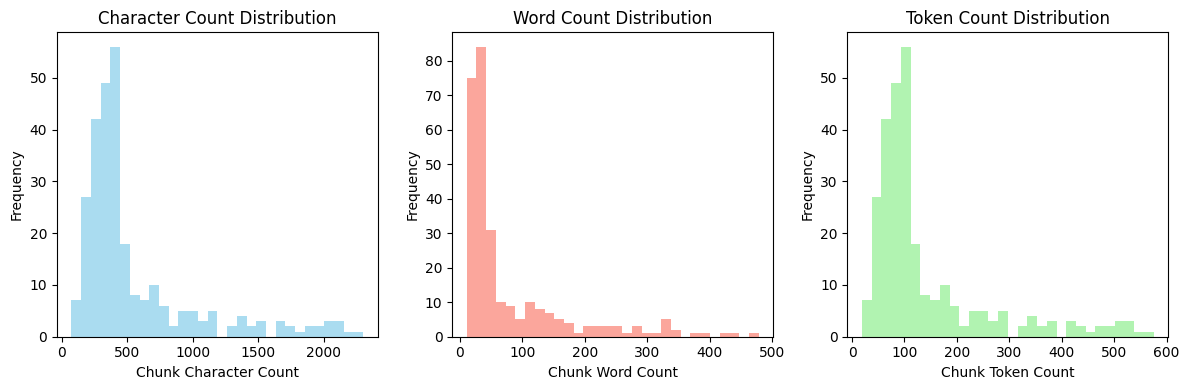

In [25]:
# Plot histograms for chunk_char_count, chunk_word_count, and chunk_token_count
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(chunks_and_embeddings_df['chunk_char_count'], bins=30, color='skyblue', alpha=0.7)
plt.title('Character Count Distribution')
plt.xlabel('Chunk Character Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(chunks_and_embeddings_df['chunk_word_count'], bins=30, color='salmon', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Chunk Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(chunks_and_embeddings_df['chunk_token_count'], bins=30, color='lightgreen', alpha=0.7)
plt.title('Token Count Distribution')
plt.xlabel('Chunk Token Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Chunk Word Count')

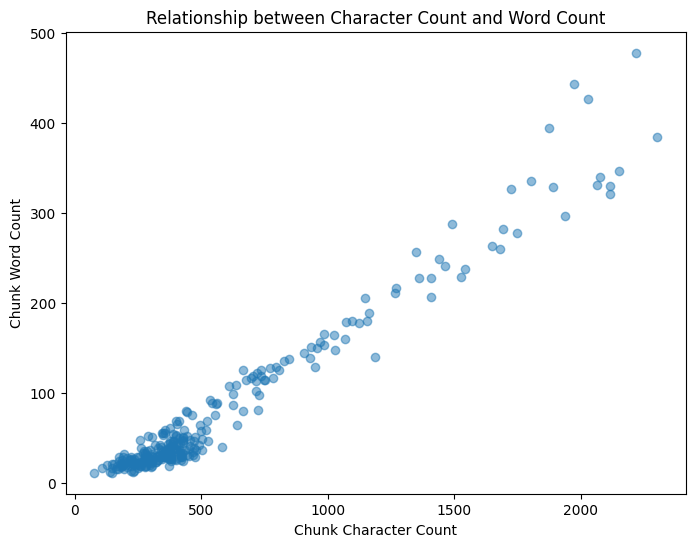

In [26]:
# Scatter plot between chunk_word_count and chunk_char_count
plt.figure(figsize=(8, 6))
plt.scatter(chunks_and_embeddings_df['chunk_char_count'], chunks_and_embeddings_df['chunk_word_count'], alpha=0.5)
plt.title('Relationship between Character Count and Word Count')
plt.xlabel('Chunk Character Count')
plt.ylabel('Chunk Word Count')

**Defining sentence transformer and LLM model**

In [27]:
# #  Define the name of the pre-trained SentenceTransformer model to use
# sent_trans_model_name = "all-mpnet-base-v2"

# # Create an instance of SentenceTransformer using the specified model name
# sent_trans_model = SentenceTransformer(sent_trans_model_name)

In [28]:
# Specify the name of the pre-trained question answering model to use
qa_model_name = "google-bert/bert-large-uncased-whole-word-masking-finetuned-squad"

# Load the tokenizer associated with the specified pre-trained model
tokenizer = AutoTokenizer.from_pretrained(qa_model_name)

# Load the pre-trained question answering model
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)

# Create a question-answering pipeline using the loaded model and tokenizer
qa_pipeline = pipeline(
    "question-answering",
    model=qa_model, # Specify the loaded question answering model
    tokenizer=tokenizer, # Specify the loaded tokenizer
    max_length=512, # Set the maximum length of input sequences
    max_answer_length=1000, # Set the maximum length of the generated answers
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Faiss similarity search, integration with LLM and UI implementation**

In [29]:
app = Flask(__name__)

data = {
    "hi": {
        "patterns": ["hello", "hi", "hey"],
        "responses": ["Hi there!", "Hello!", "Hey!"]
    },
    "how_are_you": {
        "patterns": ["how are you", "how are you doing"],
        "responses": ["I'm doing well, thank you!", "Not too bad, thanks for asking!", "I'm great, how about you?"]
    },
    "fine_great": {
        "patterns": ["fine", "great", "I am fine", "I am doing great"],
        "responses": ["Great to hear that, How can I help you?"]
    },
    "goodbye": {
        "patterns": ["bye", "see you later", "goodbye"],
        "responses": ["Goodbye!", "See you later!", "Bye!"]
    },
    "bot_name": {
        "patterns": ["what are you","what's your name", "who are you", "your name"],
        "responses": ["I'm a chatbot!", "I go by many names, but you can call me ChatBot.", "I'm your friendly ChatBot!"]
    },
    "thanks": {
        "patterns": ["thank you", "thanks"],
        "responses": ["You're welcome!", "No problem!", "Anytime!"]
    },
    "help": {
        "patterns": ["help", "what can you do", "need assistance"],
        "responses": ["Sure, I can assist you with various tasks. Just ask me anything!", "I'm here to help. Feel free to ask me anything!", "If you need assistance, don't hesitate to ask!"]
    },
    "confusion": {
        "patterns": ["I'm confused", "don't know"],
        "responses": ["ok, let me know when you are ready", "sorry to hear that"]
    },
    "create": {
        "patterns": ["who created you", "who is your creator"],
        "responses": ["Avik created me using PyTorch's machine learning library.","top secret ;)"]
    },
    "exoplanet": {
        "patterns": ["what are exoplanets", "what is exoplanet"],
        "responses": ["Exoplanets are planets that orbit stars outside our solar system"]
    },
    "detect_exoplanet": {
        "patterns": ["how do we detect exoplanet", "detect exoplanet"],
        "responses": ["Exoplanets are detected using various methods, including transit photometry (observing the dimming of a star as a planet passes in front of it) and radial velocity (detecting the wobble of a star caused by an orbiting planet)."]
    },
    "dark_matter": {
        "patterns": ["what is dark matter", "dark matter"],
        "responses": ["Dark matter is an invisible substance that makes up about 27% of the universe's mass and energy, yet its nature remains unknown and it does not emit, absorb, or reflect light."]
    },
    "clasify_galaxies": {
        "patterns": ["galaxies classified", "classify galaxy"],
        "responses": ["Galaxies are classified based on their shape, including spiral, elliptical, and irregular, determined by their visual appearance and structure."]
    },
    "types_galaxies": {
        "patterns": ["What are the different types of galaxies", "type galaxy", "types galaxies"],
        "responses": ["The different types of galaxies include spiral galaxies (with arms of stars and gas), elliptical galaxies (oval-shaped and mostly older stars), and irregular galaxies (lacking a defined shape, often with active star formation)."]
    },
    "gravitational_waves": {
        "patterns": ["gravitational waves", "gravitational wave"],
        "responses": ["ok, let me know when you are ready", "sorry to hear that"]
    },
    "detect_gravitational_waves": {
        "patterns": ["How are the gravitational waves detected", "detect gravitational waves"],
        "responses": ["Gravitational waves are detected using laser interferometers that measure tiny fluctuations in spacetime caused by passing gravitational waves."]
    },
    "time_date": {
        "patterns": ["time","date","what is the time", "what time is it", "what's today's date", "today's date"],
        "responses": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")]
    }
}

# Function to preprocess input text
def preprocess(text):
    text = text.lower()
    return text

# Function to generate response based on input text using LLM
def generate_response(input_text):
    # Initialize a FAISS index optimized for cosine similarity
    dimension = embeddings_array.shape[1]  # Dimension of embeddings
    index = faiss.IndexFlatIP(dimension)  # IP (inner product) index for cosine similarity

    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(embeddings_array)

    # Add normalized embeddings to the FAISS index
    index.add(embeddings_array)

    input_text = preprocess(input_text)

    # Check if input_text matches any predefined patterns
    for intent, intent_data in data.items():
        for pattern in intent_data["patterns"]:
            if pattern in input_text:
                if intent == "time_date":
                    return random.choice(intent_data["responses"])
                else:
                    return random.choice(intent_data["responses"])

    # Encode user input into an embedding using Sentence Transformer
    query_embedding = sent_trans_model.encode(input_text, convert_to_tensor=False)

    # Normalize the query embedding for cosine similarity
    faiss.normalize_L2(np.array([query_embedding]).astype('float32'))

    # Perform similarity search with the FAISS index using search
    k = 5  # Number of nearest neighbors to retrieve
    D, I = index.search(np.array([query_embedding]).astype('float32'), k)
    # Search for k nearest neighbors based on the query_embedding

    # Retrieve relevant text chunks based on indices for the current user input
    relevant_indices = I[0]
    print(relevant_indices) # For debugging
    relevant_chunks = chunks_and_embeddings_df.loc[relevant_indices, 'sentence_chunk'].tolist()
    # Select specific rows and column from the DataFrame

    # Combine retrieved text chunks into a single context for the user input
    llm_context = " ".join(relevant_chunks)

    # Perform question-answering for the user input using the combined context
    result = qa_pipeline(question=input_text, context=llm_context)

    # Return the answer from the LLM-based question-answering
    return result['answer']

# Route for index page
@app.route('/')
def index():
    return render_template('index_1.html')
    # Render the HTML template located in the templates folder

# Route for handling chat requests
@app.route('/chat', methods=['POST'])
def chat():
    # Extract the 'user_input' from the JSON data sent in the request;
    # default to empty string if not provided
    user_input = request.json.get("user_input", "")
    bot_response = generate_response(user_input)
    return jsonify(bot_response) # Return the bot's response as JSON

if __name__ == '__main__':
     # Set the authentication token for ngrok
    ngrok.set_auth_token("2foStyihzlfOmrmx3290SpE5qQF_7uBHAAt6t9GFvSt7rdoNB")

    # Use ngrok to expose the local server running on port 5000 (HTTP protocol)
    public_url = ngrok.connect(addr="5000", proto="http")

    # Print a formatted message with the public URL generated by ngrok
    print(f"\033[1m To access the ChatBot, Please click here ==>\033[0m {public_url}")

    # Start the Flask application
    app.run()

 To access the ChatBot, Please click here ==> NgrokTunnel: "https://f79d-34-147-59-123.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [02/May/2024 13:00:09] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/May/2024 13:00:10] "GET /favicon.ico HTTP/1.1" 404 -


[  9  11  10 115  96]


INFO:werkzeug:127.0.0.1 - - [02/May/2024 13:00:27] "POST /chat HTTP/1.1" 200 -


[277 264 276 271   0]


INFO:werkzeug:127.0.0.1 - - [02/May/2024 13:01:26] "POST /chat HTTP/1.1" 200 -
